In [2]:
%matplotlib inline

In [15]:
import pandas as pd
from skimage import io
import numpy as np
import os
import re
from PIL import Image
import math
import sklearn.svm
import sklearn.linear_model
import numpy as np
from matplotlib import pyplot as plt
#setup a standard image size; this will distort some images but will get everything into the same shape
STANDARD_SIZE = (300, 167)

In [3]:
def load_data(ids, width, height, color):
    N = len(ids)
    if color:
        d = width*height*3
    else:
        d = width*height

    data = np.zeros((N, d))
    for i, ident in enumerate(ids):
        filename = "../roof_images/" + str(ident) + '.jpg'
        image = Image.open(filename)
        resized_image = image.resize((width, height), resample=Image.ANTIALIAS)
        image_data = np.asarray(resized_image, dtype=np.uint8)
        assert image_data.shape == (height, width, 3)
        if color:
            data[i, :] = image_data.ravel()
        else:
            data[i, :] = image_data.mean(axis=2).ravel()
    return data


def load_all_data(train_ids, val_ids, test_ids, l, color):
    width = l
    height = l

    train_data = load_data(train_ids, width, height, color)
    val_data = load_data(val_ids, width, height, color)
    test_data = load_data(test_ids, width, height, color)

    return train_data, val_data, test_data

In [37]:
def four_balanced_classes():
    data = pd.read_csv("../data/train.csv")
    
    N_train = 4000
    N_val = 1000
    N_test = 1000

    ident_list = data["Id"].tolist()
    orientations =  pd.Series(data["label"].values,index=data["Id"]).to_dict()

    l1 = [ident for ident, o in orientations.items() if o == 1]
    l2 = [ident for ident, o in orientations.items() if o == 2]
    l3 = [ident for ident, o in orientations.items() if o == 3]
    l4 = [ident for ident, o in orientations.items() if o == 4]

    np.random.shuffle(l1)
    np.random.shuffle(l2)
    np.random.shuffle(l3)
    np.random.shuffle(l4)

    cut1 = int(math.floor(N_train/2))
    cut2 = int(math.floor(N_train/2+N_val/2))
    cut3 = int(math.floor(N_train/2+N_val/2+N_test/2))
    train_ids = l1[:cut1] + l2[:cut1] + l3[:cut1] + l4[:cut1]
    val_ids = l1[cut1: cut2] + l2[cut1: cut2] + l3[cut1: cut2] + l4[cut1: cut2]
    test_ids = l1[cut2: cut3] + l2[cut2: cut3] + l3[cut1: cut2] + l4[cut1: cut2]

    np.random.shuffle(train_ids)
    np.random.shuffle(val_ids)
    np.random.shuffle(test_ids)

    train_labels = np.array([int(orientations[ident]) for ident in train_ids])
    val_labels = np.array([int(orientations[ident]) for ident in val_ids])
    test_labels = np.array([int(orientations[ident]) for ident in test_ids])

    return train_ids, val_ids, test_ids, train_labels, val_labels, test_labels

In [54]:
def two_balanced_classes():
    data = pd.read_csv("../data/train.csv")
    
    N_train = 4000
    N_val = 1000
    N_test = 1000

    ident_list = data["Id"].tolist()
    orientations =  pd.Series(data["label"].values,index=data["Id"]).to_dict()

    l1 = [ident for ident, o in orientations.items() if o == 1]
    l2 = [ident for ident, o in orientations.items() if o == 2]


    np.random.shuffle(l1)
    np.random.shuffle(l2)
    np.random.shuffle(l3)
    np.random.shuffle(l4)

    cut1 = int(math.floor(N_train/2))
    cut2 = int(math.floor(N_train/2+N_val/2))
    cut3 = int(math.floor(N_train/2+N_val/2+N_test/2))
    train_ids = l1[:cut1] + l2[:cut1] 
    val_ids = l1[cut1: cut2] + l2[cut1: cut2] 
    test_ids = l1[cut2: cut3] + l2[cut2: cut3] 

    np.random.shuffle(train_ids)
    np.random.shuffle(val_ids)
    np.random.shuffle(test_ids)

    train_labels = np.array([int(orientations[ident]) for ident in train_ids])
    val_labels = np.array([int(orientations[ident]) for ident in val_ids])
    test_labels = np.array([int(orientations[ident]) for ident in test_ids])

    return train_ids, val_ids, test_ids, train_labels, val_labels, test_labels

In [44]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = four_balanced_classes()

# SVM

In [12]:
color = True

In [45]:

l_list = [5, 6, 8, 10, 13, 16]
errors = np.zeros(len(l_list))
for i, l in enumerate(l_list):
    train_data, val_data, test_data = load_all_data(train_ids, val_ids, test_ids, l, color)
    model = sklearn.svm.LinearSVC(penalty='l2', C=1e10, dual=False)
    model.fit(train_data, train_labels)
    predictions = model.predict(val_data)
    err = (predictions != val_labels).sum() / len(val_labels)
    
    errors[i] = err

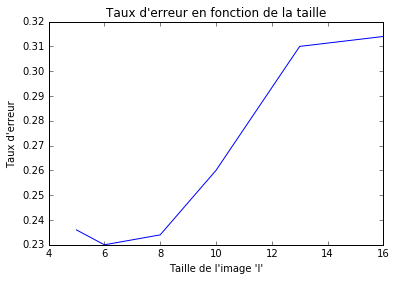

In [46]:
plt.plot(l_list, errors)
plt.title("Taux d'erreur en fonction de la taille")
plt.xlabel("Taille de l'image 'l'")
plt.ylabel("Taux d'erreur")

In [47]:
i_opt = np.argmin(errors)
l_opt = l_list[i_opt]
train_data, val_data, test_data = load_all_data(train_ids, val_ids, test_ids, l_opt, color)
model = sklearn.svm.LinearSVC(penalty='l2', C=1e10, dual=False)
model.fit(train_data, train_labels)
predictions = model.predict(test_data)
err = (predictions != test_labels).sum() / len(test_labels)
err

0.20399999999999999

In [53]:
color = False
i_opt = np.argmin(errors)
l_opt = l_list[i_opt]
train_data, val_data, test_data = load_all_data(train_ids, val_ids, test_ids, l_opt, color)
model = sklearn.svm.LinearSVC(penalty='l2', C=1e10, dual=False)
model.fit(train_data, train_labels)
predictions = model.predict(test_data)
err = (predictions != test_labels).sum() / len(test_labels)
err

0.16600000000000001

In [56]:
color = False
sub =  pd.read_csv("../data/sample_submission4.csv")
submission_ids = sub["Id"].tolist()
submission_ids
subdata = load_data(submission_ids, l_opt, l_opt, color)

In [62]:
predictions = model.predict(subdata)
predictions

(13999,)

In [64]:
sub_ids_numpy= sub["Id"].as_matrix()
sub_ids_numpy

array([766723500, 739273600, 156621880, ..., 357899800, 157694911,
       443388199], dtype=int64)

In [66]:
sub_ids_numpy.shape

(13999,)

In [76]:
output = np.column_stack((sub_ids_numpy.flatten(),predictions.flatten()))
np.savetxt('submission.csv', output, fmt="%s", delimiter=',', header = "Id,label")